# HW1 : Data Science in Twitter Data

**Required Readings:** 
* Chapter 1 and Chapter 9 of the book [Mining the Social Web](https://www.safaribooksonline.com/library/view/mining-the-social/9781491973547/?orpq) 
* The codes for Chapters 1 and 9 are in [here](https://github.com/mikhailklassen/Mining-the-Social-Web-3rd-Edition/tree/master/notebooks).

** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

## Data Collection: Download Twitter Data using API

* As the first step of Data Science process, let's collect some twitter data. Choose a keyword and search tweets containing the keyword by using Twitter search API, and then download the searched tweets (including the meta data that the Search API returns) in a file. It is recommended that the number of searched tweets should be at least 300.
* Store the tweets you downloaded into a local file (txt file or json file) 

In [ ]:
# What keyword did you choose?:  < China >

In [75]:
import sys
import operator
import requests
import json
import twitter
import oauthlib


#---------------------------------------------
# Define a Function to Login Twitter API
def oauth_login():
    # Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    CONSUMER_KEY = ''
    CONSUMER_SECRET =''
    OAUTH_TOKEN = ''
    OAUTH_TOKEN_SECRET = ''
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

def twitter_search(twitter_api, q, max_results=10000, **kw):
       
    search_results = twitter_api.search.tweets(q=q, count=10000, **kw)
    
    statuses = search_results['statuses']
    
    # Enforce a reasonable limit
    max_results = min(10000, max_results)
    
    for _ in range(100): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError as e: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses


twitter_api = oauth_login()

import flask
#print(flask.__version__)

import io, json

def save_json(filename, data):
    with open("twitterdata.json".format(filename),
              'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False)

word = "China"
results = twitter_search(twitter_api, word, max_results=50)
save_json("twitterdata.json", results)
#print(results)







### Report  statistics about the tweets you collected 

In [76]:
# The total number of tweets collected:  < 200 >

print(len(results))


198


# Data Exploration: Exploring the Tweets and Tweet Entities

**(1) Word Count:** 
* Load the tweets you collected in the local file (txt or json)
* compute the frequencies of the words being used in these tweets. 
* Plot a table of the top 30 most-frequent words with their counts

In [78]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary



def load_json(filename):
    with open("twitterdata.json".format(filename), 
              'r', encoding='utf-8') as f:
        return json.load(f)

# Sample usage

q = 'China'

twitter_api = oauth_login()
results = twitter_search(twitter_api, q, max_results=1000)

save_json(q, results)
results = load_json(q)

#print(json.dumps(results, indent=1, ensure_ascii=False))

filetexts = [ status['text'] 
                 for status in results ]

def extract_tweet_entities(statuses):
    
    # See https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object
    # for more details on tweet entities

    if len(statuses) == 0:
        return [], [], [], [], []
    
    screen_names = [ user_mention['screen_name'] 
                         for status in statuses
                            for user_mention in status['entities']['user_mentions'] ]
    
    hashtags = [ hashtag['text'] 
                     for status in statuses 
                        for hashtag in status['entities']['hashtags'] ]

    urls = [ url['expanded_url'] 
                     for status in statuses 
                        for url in status['entities']['urls'] ]
               
    # In some circumstances (such as search results), the media entity
    # may not appear
    medias = []
    symbols = []
    for status in statuses:
        if 'media' in status['entities']:
            for media in status['entities']['media']:
                medias.append(media['url'])
        if 'symbol' in status['entities']:
            for symbol in status['entities']['symbol']:
                symbols.append(symbol)
    
    return screen_names, hashtags, urls, medias, symbols

from collections import Counter

def get_common_tweet_entities(statuses, entity_threshold=2):

    # Create a flat list of all tweet entities
    tweet_entities = [  e
                        for status in statuses
                            for entity_type in extract_tweet_entities([status]) 
                                for e in entity_type 
                     ]

    c = Counter(tweet_entities).most_common()

    # Compute frequencies
    return [ (k,v) 
             for (k,v) in c
                 if v >= entity_threshold
           ]

# Sample usage

common_entities = get_common_tweet_entities(results)

while len(common_entities) >= 30:
    del common_entities[-1]

pt = PrettyTable(field_names=['Entity', 'Count']) 
[ pt.add_row(kv) for kv in common_entities ]
pt.align['Entity'], pt.align['Count'] = 'l', 'r' # Set column alignment
pt._max_width = {'Entity':60, 'Count':10}
print(pt)


+----------------------------------------------------+-------+
| Entity                                             | Count |
+----------------------------------------------------+-------+
| YinHaoyu网络视听盛典                               |    58 |
| แพทริค                                              |    51 |
| China                                              |    33 |
| patrick_pppat                                      |    30 |
| gleisi                                             |    25 |
| CollinRugg                                         |    24 |
| ACTBrigitte                                        |    22 |
| MattWallace888                                     |    22 |
| JackPosobiec                                       |    21 |
| patrick_THFC                                       |    18 |
| nidepaipai                                         |    17 |
| HowThingsWork_                                     |    17 |
| Realitymeta                                        |    15

** (2) Find the most popular tweets in your collection of tweets**

Please plot a table of the top 10 most-retweeted tweets in your collection, i.e., the tweets with the largest number of retweet counts.


In [79]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

search_results = twitter_api.search.tweets(q=q, count=5000)

statuses = search_results['statuses']

retweets = [
            # Store out a tuple of these three values ...
            (status['retweet_count'], 
             status['retweeted_status']['user']['screen_name'],
             status['retweeted_status']['id'],
             status['text']) 
            
            # ... for each status ...
            for status in statuses 
            
            # ... so long as the status meets this condition.
                if 'retweeted_status' in status.keys()
           ]

# Slice off the first 5 from the sorted results and display each item in the tuple

pt = PrettyTable(field_names=['Count', 'Screen Name', 'Tweet ID', 'Text'])
[ pt.add_row(row) for row in sorted(retweets, reverse=True)[:10] ]
pt.max_width['Text'] = 50
pt.align= 'l'
print(pt)










+-------+----------------+---------------------+----------------------------------------------------+
| Count | Screen Name    | Tweet ID            | Text                                               |
+-------+----------------+---------------------+----------------------------------------------------+
| 7730  | MattWallace888 | 1617547153945300994 | RT @MattWallace888: Do you support Elon Musk       |
|       |                |                     | buying farmland so China and Bill Gates can’t get  |
|       |                |                     | it?                                                |
| 4719  | RepAdamSchiff  | 1614346081525194753 | RT @RepAdamSchiff: Threats around the world are    |
|       |                |                     | serious and growing. From Russia and China to the  |
|       |                |                     | rise of authoritarianism.                          |
|       |                |                     |                                  

**(3) Find the most popular Tweet Entities in your collection of tweets**

Please plot the top 10 most-frequent hashtags and top 10 most-mentioned users in your collection of tweets.

In [83]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

def get_common_tweet_entities(statuses, entity_threshold=2):

    # Create a flat list of all tweet entities
    tweet_entities = [  e
                        for status in statuses
                            for entity_type in extract_tweet_entities([status]) 
                                for e in entity_type 
                     ]
    hashtags = [ hashtag['text'] 
                     for status in statuses 
                        for hashtag in status['entities']['hashtags'] ]

    c = Counter(hashtags).most_common()

    # Compute frequencies
    return [ (k,v) 
             for (k,v) in c
                 if v >= entity_threshold
           ]

# Sample usage


common_entities = get_common_tweet_entities(results)

while len(common_entities) > 10:
    del common_entities[-1]


pt = PrettyTable(field_names=['Entity', 'Count']) 
[ pt.add_row(kv) for kv in common_entities ]
pt.align['Entity'], pt.align['Count'] = 'l', 'r' # Set column alignment
pt._max_width = {'Entity':60, 'Count':10}
print(pt)

def get_common_tweet_entities2(statuses, entity_threshold=2):

    # Create a flat list of all tweet entities
    tweet_entities = [  e
                        for status in statuses
                            for entity_type in extract_tweet_entities([status]) 
                                for e in entity_type 
                     ]
    screen_names = [ user_mention['screen_name'] 
                         for status in statuses
                            for user_mention in status['entities']['user_mentions'] ]

    c = Counter(screen_names).most_common()

    # Compute frequencies
    return [ (k,v) 
             for (k,v) in c
                 if v >= entity_threshold
           ]

# Sample usage


common_entities = get_common_tweet_entities2(results)

while len(common_entities) > 10:
    del common_entities[-1]


pt = PrettyTable(field_names=['Entity', 'Count']) 
[ pt.add_row(kv) for kv in common_entities ]
pt.align['Entity'], pt.align['Count'] = 'l', 'r' # Set column alignment
pt._max_width = {'Entity':60, 'Count':10}
print(pt)





+----------------------+-------+
| Entity               | Count |
+----------------------+-------+
| YinHaoyu网络视听盛典 |    58 |
| แพทริค                |    51 |
| China                |    33 |
| Gleam                |    15 |
| 2023网络视听年度盛典 |     8 |
| 尹浩宇               |     7 |
| INTO1Patrick         |     7 |
| INTO1                |     7 |
| BornToFly            |     7 |
| NarrativeBreakerShiv |     7 |
+----------------------+-------+
+----------------+-------+
| Entity         | Count |
+----------------+-------+
| patrick_pppat  |    30 |
| gleisi         |    25 |
| CollinRugg     |    24 |
| ACTBrigitte    |    22 |
| MattWallace888 |    22 |
| JackPosobiec   |    21 |
| patrick_THFC   |    18 |
| nidepaipai     |    17 |
| HowThingsWork_ |    17 |
| Realitymeta    |    15 |
+----------------+-------+


Plot a histogram of the number of user mentions in the list using the following bins.

Text(0, 0.5, 'Number of tweets in bin')

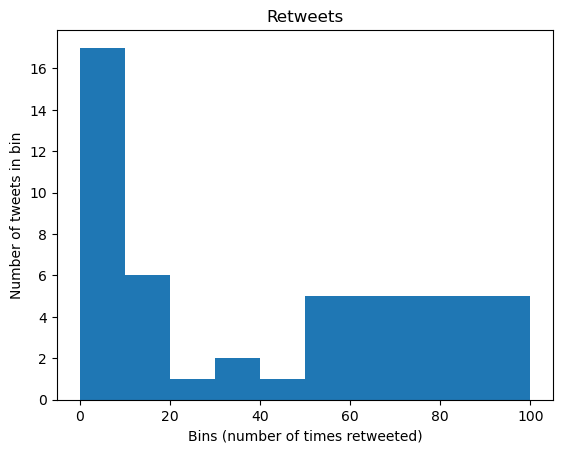

In [92]:
bins=[0, 10, 20, 30, 40, 50, 100]

# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

import matplotlib.pyplot as plt
%matplotlib inline

screen_names = [ user_mention['screen_name'] 
                 for status in statuses
                     for user_mention in status['entities']['user_mentions'] ]


counts = [count for count, _, _, _ in retweets]


plt.hist(counts, bins)
plt.title('Retweets')
plt.xlabel('Bins (number of times retweeted)')
plt.ylabel('Number of tweets in bin')





 ** (optional task for fun) Getting "All" friends (followees) and "All" followers of a popular user in the tweets**

* choose a popular twitter user who has many followers in your collection of tweets.
* Get the list of all friends and all followers of the twitter user.
* Plot 20 out of the followers, plot their ID numbers and screen names in a table.
* Plot 20 out of the friends (if the user has more than 20 friends), plot their ID numbers and screen names in a table.

In [35]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary







*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook.

** How to submit: **

        Please submit through Canvas, in the Assignment "HW1".
        